In [1]:
import os
import random
import sys

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# for statistics
from scipy.stats import kstest

# preprocessing
from sklearn.preprocessing import StandardScaler

# ml methods
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM

# metrics
from sklearn.metrics import f1_score

def seed_everything(seed):
    # фискирует максимум сидов для корректности сравнения разных экспериментов
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    # torch.manual_seed(seed)
    # torch.cuda.manual_seed(seed)
    # torch.backends.cudnn.deterministic = True

seed_everything(42)

# Datasets

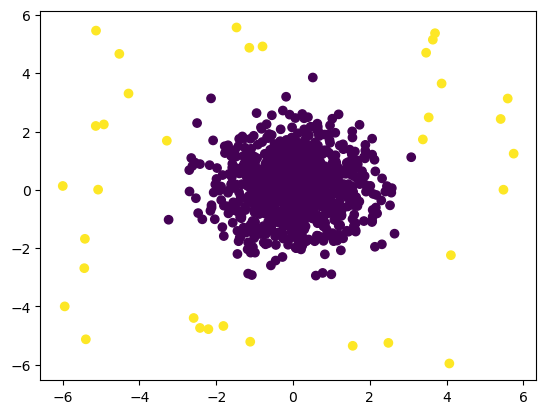

In [2]:
# Синтетически сгенерированные нормально распределенные данные
data_norm = pd.DataFrame(data=np.random.normal(
                        loc=0, scale=1, size=(1000, 2)), 
                       columns=['x', 'y'])
data_noise = pd.DataFrame(data=np.random.uniform(
                        low=-6, high=6, size=(int(data_norm.shape[0]*.05), data_norm.shape[1])), 
                        columns=['x', 'y'])
filter = (
    (data_noise['x'] < data_norm['x'].min())
    | (data_noise['x'] > data_norm['x'].max())
    | (data_noise['y'] < data_norm['y'].min())
    | (data_noise['y'] > data_norm['y'].max())
    )
data_noise = data_noise[filter]
data_norm['anomaly'] = 0
data_noise['anomaly'] = 1

df_norm = pd.concat((data_norm, data_noise))
plt.scatter(df_norm['x'], df_norm['y'], c=df_norm['anomaly'])
plt.show()

In [10]:
# SKAB data

# from google.colab import drive
# drive.mount('/content/drive')
# ! cp -r /content/drive/MyDrive/Study/MIPT_magistery/qualification_work/data .


all_files=[]
for root, dirs, files in os.walk("data/"):
    for file in files:
        if file.endswith(".csv"):
             all_files.append(os.path.join(root, file))

# формируем датафрейм
dfs=[]
for path in all_files:
    df = pd.read_csv(path,index_col='datetime',sep=';',parse_dates=True)
    print(path, df.shape)
    dfs.append(df)
print('Features:')
for col in dfs[2].columns:
    print('\t',col)
dfs = [df for df in dfs if df.shape[1] == 10]
df_skab = pd.concat(dfs)
print(df_skab.shape)
df_skab = df_skab.drop_duplicates()
df_skab = df_skab.drop('changepoint', axis=1)
display(df_skab)

data/valve1/2.csv (1075, 10)
data/valve1/1.csv (1145, 10)
data/valve1/11.csv (1141, 10)
data/valve1/8.csv (1144, 10)
data/valve1/10.csv (1146, 10)
data/valve1/0.csv (1147, 10)
data/valve1/13.csv (1140, 10)
data/valve1/6.csv (1154, 10)
data/valve1/9.csv (1148, 10)
data/valve1/12.csv (1140, 10)
data/valve1/15.csv (1150, 10)
data/valve1/4.csv (1095, 10)
data/valve1/3.csv (1148, 10)
data/valve1/5.csv (1154, 10)
data/valve1/7.csv (1094, 10)
data/valve1/14.csv (1139, 10)
data/valve2/2.csv (1129, 10)
data/valve2/1.csv (1063, 10)
data/valve2/0.csv (1125, 10)
data/valve2/3.csv (995, 10)
data/anomaly-free/anomaly-free.csv (9405, 8)
data/other/2.csv (780, 10)
data/other/1.csv (745, 10)
data/other/11.csv (1190, 10)
data/other/8.csv (1147, 10)
data/other/10.csv (1327, 10)
data/other/13.csv (923, 10)
data/other/6.csv (1147, 10)
data/other/9.csv (1144, 10)
data/other/12.csv (1048, 10)
data/other/4.csv (1191, 10)
data/other/3.csv (1137, 10)
data/other/5.csv (1155, 10)
data/other/7.csv (1090, 10)
data/

,Accelerometer1RMS,Accelerometer2RMS,Current,Pressure,Temperature,Thermocouple,Voltage,Volume Flow RateRMS,anomaly
datetime,,,,,,,,,
2020-03-09 10:54:34,0.026990,0.040407,1.015510,0.382638,72.9570,25.6198,231.276,31.00100,0.0
2020-03-09 10:54:35,0.026836,0.039138,1.020390,0.054711,72.8664,25.6185,226.683,31.99900,0.0
2020-03-09 10:54:36,0.026597,0.040147,0.733759,0.054711,72.8498,25.6157,231.091,31.00100,0.0
2020-03-09 10:54:37,0.027161,0.040001,1.073280,0.382638,72.7915,25.6115,236.156,31.99900,0.0
2020-03-09 10:54:38,0.026703,0.039407,1.106890,0.054711,72.9818,25.6171,207.464,31.00100,0.0
...,...,...,...,...,...,...,...,...,...
2020-02-08 19:32:15,0.105811,0.193051,1.291030,0.054711,86.1452,33.2491,208.855,122.47500,0.0
2020-02-08 19:32:16,0.060570,0.077031,0.824930,0.382638,86.2657,33.2489,227.430,98.54010,0.0
2020-02-08 19:32:17,0.024764,0.037350,0.293163,0.382638,86.5109,33.2445,228.719,69.18940,0.0


# Статический метод выявления выбросов (3 сигма)

In [11]:
def check_kstest(df, alpha=0.05):
    columns = list(df.columns)
    cols_with_pos_res = []
    for col in columns:
        if kstest(df[col], 'norm').pvalue > alpha:
            cols_with_pos_res.append(col)
    return cols_with_pos_res

def outliers_z_score(data, feature):
    x = data[feature]
    mu = x.mean()
    sigma = x.std()
    lower_bound = mu - 3 * sigma
    upper_bound = mu + 3 * sigma
    outliers = data[(x < lower_bound) | (x > upper_bound)]
    cleaned = data[(x > lower_bound) & (x < upper_bound)]
    print(f'Признак {feature}. Число выбросов по методу z-отклонения: {outliers.shape[0]}')
    return outliers

def z_score_method(df):
    """
    Метод работает с нормально распределенными данными,
    при чем с небольшим (до 10%) количеством выбросов.
    С ненормально распределенными данными не работает.
    """
    norm_cols = check_kstest(df)
    if norm_cols:
        outliers = pd.DataFrame()
        for col in norm_cols:
            outliers = pd.concat((outliers, outliers_z_score(df, col)))
        outliers = outliers.drop_duplicates()
        outliers['anomaly_preds'] = 1
        df_with_marked_outliers = df.merge(outliers, how='outer').fillna(0)
        return outliers, df_with_marked_outliers
    else:
        print('The data are not normally distributed')
        return None, df

# Метрики

In [12]:
# f1_score
def score_metrics(real_outliers, pred_outliers):
    scores = {}
    scores['f1_score'] = f1_score(real_outliers, pred_outliers)
    return scores

Ищем выбросы

In [13]:
outliers, df_norm = z_score_method(df_norm)
if outliers is not None:
    print(score_metrics(df_norm['anomaly'], df_norm['anomaly_preds']))

Признак x. Число выбросов по методу z-отклонения: 20
Признак y. Число выбросов по методу z-отклонения: 19
{'f1_score': 0.9393939393939394}


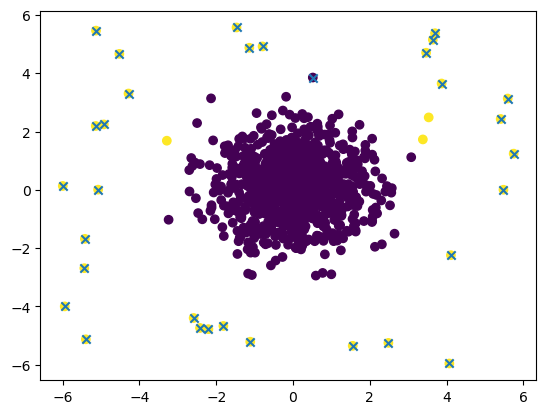

In [14]:
plt.scatter(df_norm['x'], df_norm['y'], c=df_norm['anomaly'])
plt.scatter(outliers['x'], outliers['y'], marker='x')
plt.show()

In [15]:
outliers, df_skab = z_score_method(df_skab)

The data are not normally distributed


# ML методы

## Unsupervised

In [16]:
def ml_method(df, method, **qwargs):
    X = df.copy()
    y = X.pop('anomaly')

    # preprocessing
    columns = list(X.columns)
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    X = pd.DataFrame(data=X, columns=columns)

    model = method(**qwargs).fit(X)
    pred = model.predict(X)
    pred[pred == 1] = 0
    pred[pred == -1] = 1
    print(method.__name__)
    print(score_metrics(y, pred))

In [18]:
print('df_skab')
ml_method(df_skab, IsolationForest, n_estimators=50)
print('df_norm')
ml_method(df_norm, IsolationForest, n_estimators=50)

df_skab
IsolationForest
{'f1_score': 0.396246876326088}
df_norm
IsolationForest
{'f1_score': 0.40476190476190477}


## Semi-supervised

In [19]:
print('df_skab')
ml_method(df_skab, OneClassSVM, 
          kernel='rbf', degree=3, gamma='scale', 
          coef0=0.0, tol=0.001, nu=0.5)
print('df_norm')
ml_method(df_norm, OneClassSVM, 
          kernel='rbf', degree=3, gamma='scale', 
          coef0=0.0, tol=0.001, nu=0.5)

df_skab
OneClassSVM
{'f1_score': 0.4587033747779751}
df_norm
OneClassSVM
{'f1_score': 0.12363636363636363}
